In [80]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

tickers = ["SPY", "QQQ", "IWM", "EEM", "AAPL"]

In [81]:
data= yf.download(tickers, start="2023-1-1", auto_adjust = False, progress=False)
returns = data['Adj Close'].pct_change().dropna()

In [82]:
window = 20 
ma_20 = data['Adj Close'].rolling(window = window).mean()
std_20 = data['Adj Close'].rolling(window = window).std()
z_score = (data['Adj Close'] - ma_20) / std_20

In [83]:
def z_to_signal(z):
    if pd.isna(z):
        return 0
    elif z < -1:
        return 1
    elif z > 1:
        return -1
    else: 
        return 0

signal = z_score.apply(lambda col:col.map(z_to_signal))

In [84]:
cov_window = 60
rolling_var = returns.rolling(cov_window).var()
inv_var = 1/rolling_var
weights = inv_var.div(inv_var.sum(axis=1), axis = 0)

In [85]:
common_index = signal.index.intersection(weights.index)
signal_aligned = signal.loc[common_index]
weights_aligned = weights.loc[common_index]

positions = signal_aligned * weights_aligned

In [86]:
def cumulative_return(position, prices):
    common_index = position.index.intersection(prices.index)
    pos = position.loc[common_index]
    pri = prices.loc[common_index]
    
    # Calculate portfolio value using beginning-of-period positions
    portfolio_value = (pri * pos.shift(1)).sum(axis=1)
    
    # Calculate dollar change in portfolio
    dollar_change_port = (pri.diff() * pos.shift(1)).sum(axis=1)
    
    # Calculate period returns (dollar change / portfolio value at start of period)
    period_returns = dollar_change_port / portfolio_value
    period_returns = period_returns.dropna()
    
    # Calculate cumulative return
    cumulative_return = (1 + period_returns).cumprod()
    
    return cumulative_return   



<Axes: xlabel='Date'>

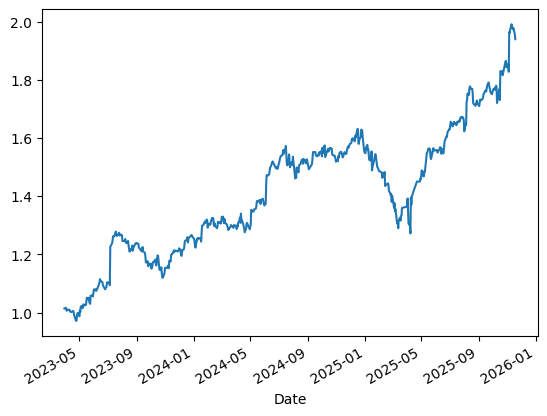

In [87]:
final = cumulative_return(positions, data['Adj Close'])
final.plot()